In [1]:
### Import packages
import numpy as np 
# data processing
import pandas as pd 
# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

#selected plotting functions
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.datasets import make_blobs

# Train-test split
from sklearn.model_selection import train_test_split
from collections import Counter

# Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,confusion_matrix,roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
from sklearn.svm import SVC
from xgboost import XGBClassifier
import xgboost as xgb
##(the full code for xgboost is taken from the following website: 
## https://towardsdatascience.com/binary-classification-xgboost-hyperparameter-tuning-scenarios-by-non-exhaustive-grid-search-and-c261f4ce098d)

# learning curve
from sklearn.model_selection import learning_curve

# Class prediction error
from yellowbrick.classifier import ClassPredictionError

#feature importance
import eli5 as eli
from sklearn.inspection import permutation_importance
import shap

# Hypothesis testing for comparing algorithms: whether the difference between two models is real and not just a statistical fluke
from mlxtend.evaluate import paired_ttest_5x2cv

#creating deepcopy of model instances
from copy import deepcopy

#Python standard libraries
import time
import warnings

#setting default resolution of figures
mpl.rcParams['figure.dpi'] = 100

In [2]:
data=pd.read_pickle("data_readyforanalysis.pkl")
#### GET DUMMIES FOR THE  DATASET EXCEPT TARGET FEATURE (ALL FEATURES ARE CATEGORICAL)
data = pd.get_dummies(data=data, columns=['age', 'gender','educ','experience','ML_exp','comp_size','team','ML_buss','salary','ML_spent','region'], drop_first=True)
data=data.astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5670 entries, 1 to 20035
Data columns (total 37 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Python_or       5670 non-null   category
 1   data_tool       5670 non-null   category
 2   title           5670 non-null   category
 3   age_2.0         5670 non-null   category
 4   age_3.0         5670 non-null   category
 5   age_4.0         5670 non-null   category
 6   age_5.0         5670 non-null   category
 7   gender_1.0      5670 non-null   category
 8   gender_2.0      5670 non-null   category
 9   educ_1.0        5670 non-null   category
 10  educ_2.0        5670 non-null   category
 11  educ_3.0        5670 non-null   category
 12  experience_1.0  5670 non-null   category
 13  experience_2.0  5670 non-null   category
 14  experience_3.0  5670 non-null   category
 15  ML_exp_1.0      5670 non-null   category
 16  ML_exp_2.0      5670 non-null   category
 17  ML_exp_3.0   

In [3]:
#Train-test split
X = data.drop(columns=['title']).values
y = data['title'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, stratify=y, random_state=600)
# Visualization
data_vis=data.drop('title', axis=1)
print('training set: {0}，test set: {1}'.format(X_train.shape[0], X_test.shape[0]))

training set: 3798，test set: 1872


In [4]:
print(Counter(y_train))
print(Counter(y_test))

Counter({0.0: 2006, 1.0: 1792})
Counter({0.0: 988, 1.0: 884})


# FIRST ALGORITHM is GAUSSIAN NAIVE BAYES:
# Try it first if: we have categorical labels and features, and need code to be simple.
# Disadvantages:The assumption of independent features. In practice, it is almost impossible that model will get a set of predictors which are entirely independent

              precision    recall  f1-score   support

         0.0       0.65      0.72      0.68       988
         1.0       0.64      0.57      0.60       884

    accuracy                           0.65      1872
   macro avg       0.65      0.64      0.64      1872
weighted avg       0.65      0.65      0.64      1872

Train Accuracy: 63.63875724065298%
Test Accuracy: 64.58333333333334%


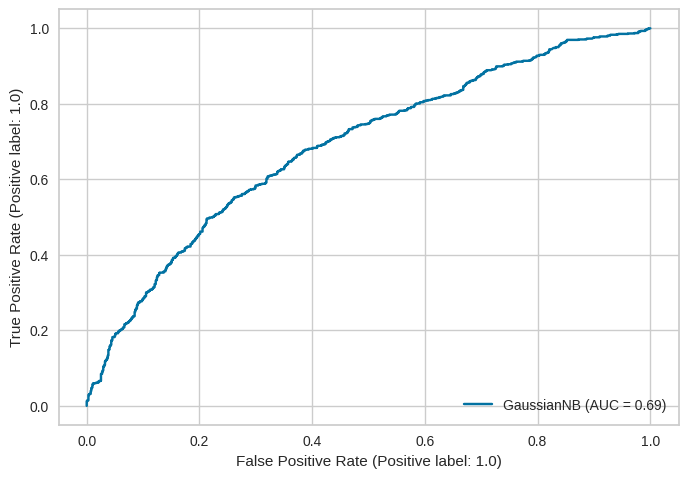

In [5]:
gnb = GaussianNB()
#Train the model using the training sets
gnb.fit(X_train, y_train)
#Predict the response for test dataset
y_pred = gnb.predict(X_test)
print(classification_report(y_test, y_pred))
print(f'Train Accuracy: {gnb.score(X_train,y_train)*100}%')
print(f'Test Accuracy: {gnb.score(X_test,y_test)*100}%')
gnb_accuracy=gnb.score(X_test,y_test)*100
gnb_accuracy=gnb_accuracy.round(decimals=2)
gnb_disp = RocCurveDisplay.from_estimator(gnb, X_test, y_test)

### SECOND ALGORITHM: Support Vector Machines is used here for the following reasons: we've got binary labels, may need a flexible boundary shape(not just linear), works in a moderate scale.

In [6]:
### Let's first check how the classes are well separated by making blobs.
for i in set(y): ###find the std
    print('--> label {}'.format(i))
    for j in range(X.shape[1]):
        print('std for feature {}: {}'.format(j, np.std(X[y==i][:,j])))

--> label 0.0
std for feature 0: 0.3678282879374974
std for feature 1: 0.48739630620827806
std for feature 2: 0.45660670200743514
std for feature 3: 0.31646128665030293
std for feature 4: 0.2000177256047182
std for feature 5: 0.12687875064596654
std for feature 6: 0.39701352289232794
std for feature 7: 0.38559438048528555
std for feature 8: 0.4698468154459577
std for feature 9: 0.49897083249339325
std for feature 10: 0.28403568661152306
std for feature 11: 0.48992520067636613
std for feature 12: 0.4913027957620788
std for feature 13: 0.3570386796845836
std for feature 14: 0.47222462068931886
std for feature 15: 0.43501862933285407
std for feature 16: 0.3844876221720116
std for feature 17: 0.28975631360235593
std for feature 18: 0.12939825601220972
std for feature 19: 0.45734821355260685
std for feature 20: 0.3637825042241114
std for feature 21: 0.4863820989063886
std for feature 22: 0.42838519699924255
std for feature 23: 0.44509798017349594
std for feature 24: 0.3606039047477556
std f

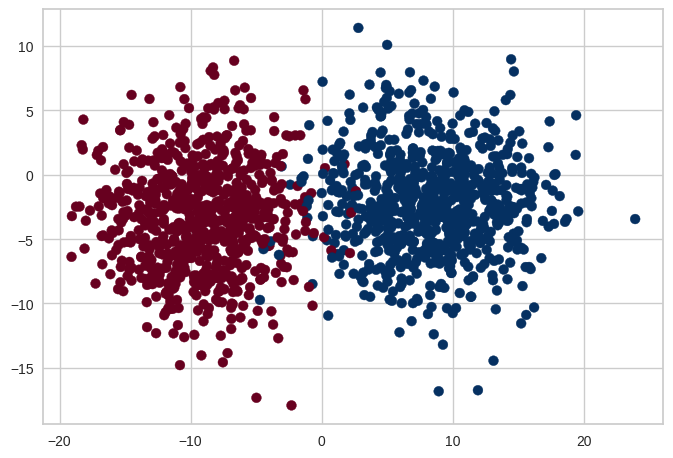

In [7]:
X, y = make_blobs(1500, 2, centers=2, random_state=214, cluster_std=4)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')

              precision    recall  f1-score   support

         0.0       0.69      0.67      0.68       988
         1.0       0.64      0.66      0.65       884

    accuracy                           0.67      1872
   macro avg       0.67      0.67      0.67      1872
weighted avg       0.67      0.67      0.67      1872

Train Accuracy: 74.96050552922591%
Test Accuracy: 66.82692307692307%


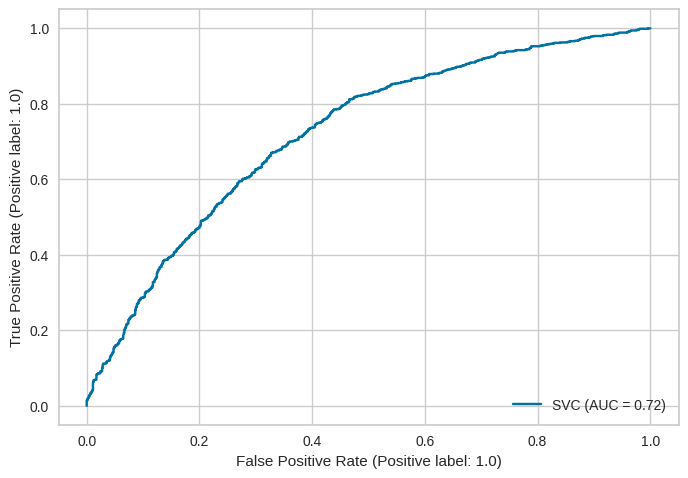

In [8]:
model_svc=SVC()### kernel=rbf is the default.
model_svc.fit(X_train,y_train)
y_pred_svc=model_svc.predict(X_test)
print(classification_report(y_test, y_pred_svc)) 
print(f'Train Accuracy: {model_svc.score(X_train,y_train)*100}%')
print(f'Test Accuracy: {model_svc.score(X_test,y_test)*100}%')
svc_accuracy=model_svc.score(X_test,y_test)*100
svc_disp = RocCurveDisplay.from_estimator(model_svc, X_test, y_test)
### OVERFITTING: though the overall performance of the model is not good enough,
### there exists 10% difference of accuracy btw train and test sets.

In [9]:
param_grid_svm = {
    'kernel': ['linear','rbf'],                      
    'C': [0.1, 1, 10],
    'gamma': [1,0.1,0.01] 
}
grid_svm = GridSearchCV(SVC(),param_grid_svm,refit=True,verbose=2)
grid_svm.fit(X_train,y_train)
print(grid_svm.best_params_)

[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   0.7s
{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


[[655 333]
 [284 600]]
              precision    recall  f1-score   support

         0.0       0.70      0.66      0.68       988
         1.0       0.64      0.68      0.66       884

    accuracy                           0.67      1872
   macro avg       0.67      0.67      0.67      1872
weighted avg       0.67      0.67      0.67      1872

Train Accuracy: 72.3012111637704%
Test Accuracy: 67.04059829059828%


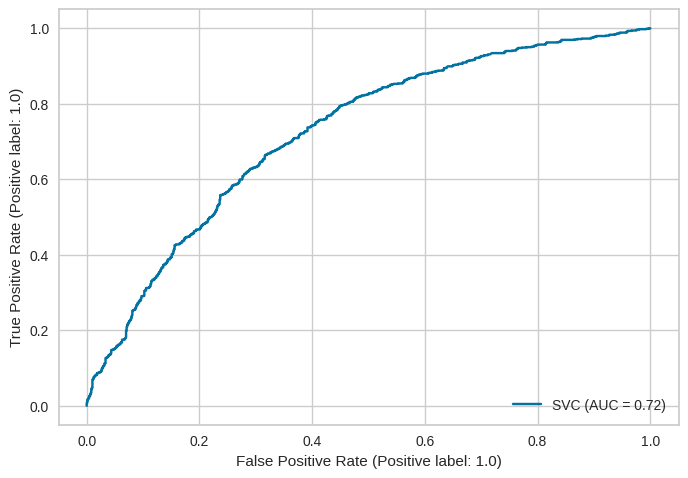

In [9]:
best_svm=SVC(C=1, gamma=0.1, kernel='rbf', random_state=601)
best_svm.fit(X_train,y_train)
best_ysvm = best_svm.predict(X_test)
print(confusion_matrix(y_test,best_ysvm))
print(classification_report(y_test,best_ysvm))
print(f'Train Accuracy: {best_svm.score(X_train,y_train)*100}%')
print(f'Test Accuracy: {best_svm.score(X_test,y_test)*100}%')
svmbest_accuracy=best_svm.score(X_test,y_test)*100
svmbest_accuracy=svmbest_accuracy.round(decimals=2)
svmbest_disp = RocCurveDisplay.from_estimator(best_svm, X_test, y_test)

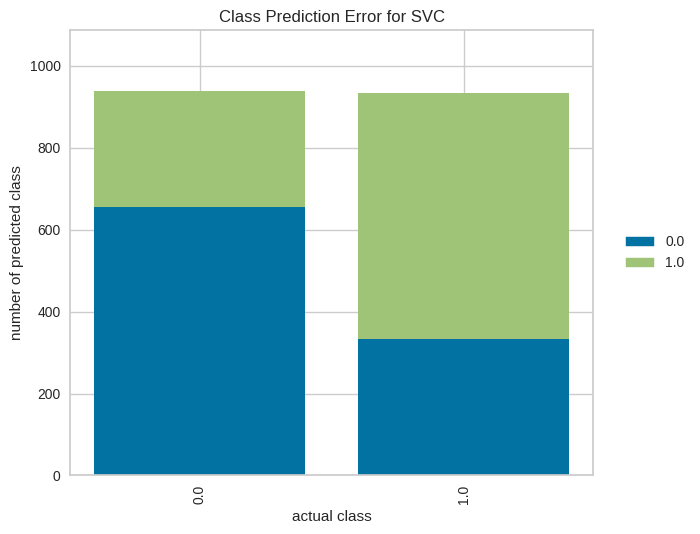

<AxesSubplot:title={'center':'Class Prediction Error for SVC'}, xlabel='actual class', ylabel='number of predicted class'>

In [10]:
# Instantiate the classification model and visualizer
visualizer = ClassPredictionError(
    SVC(C=1, gamma=0.1, kernel='rbf', random_state=601), classes=[0.0, 1.0]
)

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
visualizer.show()

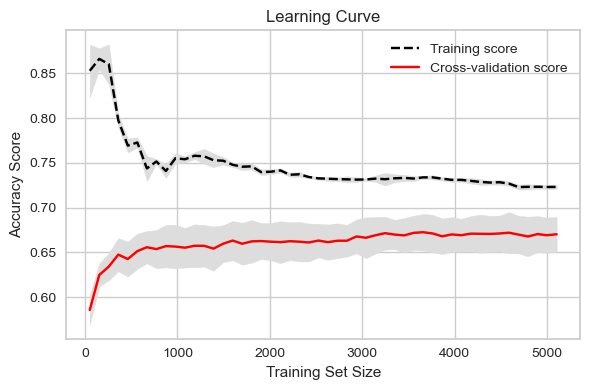

In [12]:
# Create CV training and test scores for various training set sizes
train_sizes_svc, train_scores_svc, test_scores_svc = learning_curve(SVC(C=1, gamma=0.1, kernel='rbf', random_state=601), X, y, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean_svc = np.mean(train_scores_svc , axis=1)
train_std_svc = np.std(train_scores_svc , axis=1)

# Create means and standard deviations of test set scores
test_mean_svc = np.mean(test_scores_svc , axis=1)
test_std_svc = np.std(test_scores_svc , axis=1)

# Draw lines
plt.plot(train_sizes_svc , train_mean_svc, '--', color="black",  label="Training score")
plt.plot(train_sizes_svc , test_mean_svc , color="red", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes_svc , train_mean_svc  - train_std_svc , train_mean_svc  + train_std_svc , color="#DDDDDD")
plt.fill_between(train_sizes_svc , test_mean_svc  - test_std_svc , test_mean_svc  + test_std_svc , color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

### Performance Learning Curves: Learning curves calculated on the metric by which the model will be evaluated and selected, such as accuracy, precision, recall, or F1 score.

### Third ALGORITHM: Logistic Regression can be used first if: we've got binary labels, diminishing returns to changes in feature values, and want to do ranking or get probabilities as the labels.

In [11]:
### Log Reg: base model
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print ("Confusion Matrix : \n", cm)
print ("Accuracy : ", accuracy_score(y_test, y_pred))
print(f'Test Accuracy: {classifier.score(X_test,y_test)*100}%')
roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1])

Confusion Matrix : 
 [[675 313]
 [317 567]]
Accuracy :  0.6634615384615384
Test Accuracy: 66.34615384615384%


0.7181912589077984

In [14]:
### Log Reg: GridSearch for the best parameters and model
param_grid_lr = {
    'max_iter': [100, 200, 500, 1000],                      
    'class_weight': ['balanced'],
    'penalty':['l2'],
    'C': [0.001, 0.01, 0.1, 0.15],
    'solver': ['lbfgs', 'liblinear'] 
}
logModel_grid = GridSearchCV(estimator=LogisticRegression(random_state=1235), param_grid=param_grid_lr, verbose=1, cv=10, n_jobs=-1)
logModel_grid.fit(X_train, y_train)
print(logModel_grid.best_params_)

Fitting 10 folds for each of 32 candidates, totalling 320 fits
{'C': 0.1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}


[[632 356]
 [275 609]] : is the confusion matrix 

0.6629273504273504 : is the accuracy score 

0.7157719557770166 : is the roc score 



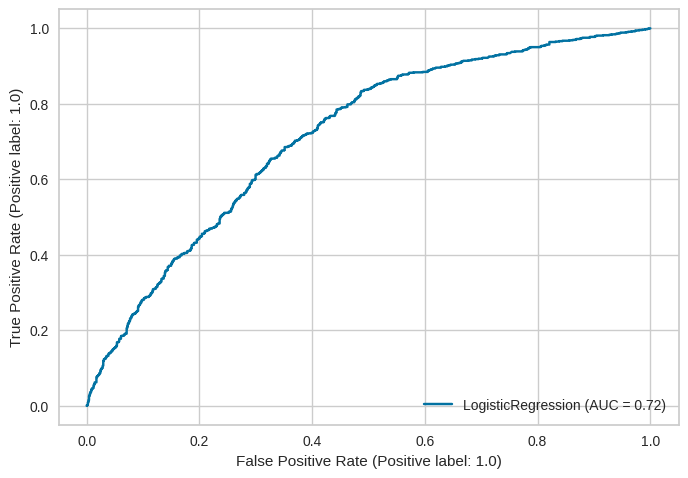

In [12]:
lr_bestmodel=LogisticRegression(C=0.1, class_weight='balanced',max_iter=100, penalty='l2', solver='liblinear', random_state=502)
lr_bestmodel.fit(X_train,y_train)
y_bestpred=lr_bestmodel.predict(X_test)
print(confusion_matrix(y_test, y_bestpred), ": is the confusion matrix \n")
print(accuracy_score(y_test, y_bestpred), ": is the accuracy score \n")
print(roc_auc_score(y_test, lr_bestmodel.predict_proba(X_test)[:, 1]), ": is the roc score \n")
lr_accuracy=lr_bestmodel.score(X_test,y_test)*100
lr_accuracy=lr_accuracy.round(decimals=2)
lr_disp = RocCurveDisplay.from_estimator(lr_bestmodel, X_test, y_test)

In [13]:
print(f'Train Accuracy: {lr_bestmodel.score(X_train,y_train)*100}%')
print(f'Test Accuracy: {lr_bestmodel.score(X_test,y_test)*100}%')

Train Accuracy: 67.19325961032122%
Test Accuracy: 66.29273504273505%


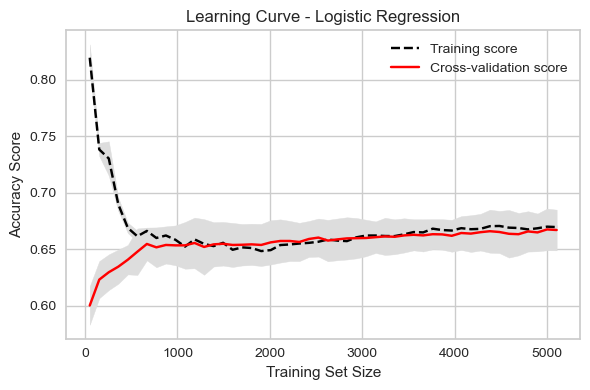

In [32]:
# Create CV training and test scores for various training set sizes
train_sizes_lr, train_scores_lr, test_scores_lr = learning_curve(LogisticRegression(C=0.1, class_weight='balanced',max_iter=100, penalty='l2', solver='liblinear', random_state=502), 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean_lr = np.mean(train_scores_lr, axis=1)
train_std_lr = np.std(train_scores_lr, axis=1)

# Create means and standard deviations of test set scores
test_mean_lr= np.mean(test_scores_lr, axis=1)
test_std_lr= np.std(test_scores_lr, axis=1)

# Draw lines
plt.plot(train_sizes_lr, train_mean_lr, '--', color="black",  label="Training score")
plt.plot(train_sizes_lr, test_mean_lr, color="red", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes_lr, train_mean_lr - train_std_lr, train_mean_lr + train_std_lr, color="#DDDDDD")
plt.fill_between(train_sizes_lr, test_mean_lr - test_std_lr, test_mean_lr + test_std_lr, color="#DDDDDD")

# Create plot
plt.title("Learning Curve - Logistic Regression")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

### The generalization gap for the training and validation curve becomes extremely small as the training dataset size increases. This indicates that adding more examples to our model is not going to improve its performance. A solution to this problem may be to create more features or to make the model more flexible to reduce the number of assumptions being made.

###The two curves have already congerved. Adding more training instances is very unlikely to help here.

In [14]:
# Which algorithm (SVM or Logistic Regression) gave better results? Firstly, are these algorithms significantly different from each other?
###### let's assume a significance threshold of α=0.05 for rejecting the null hypothesis that both algorithms perform equally well on the dataset and conduct the 5x2cv t test:
### Since p>α, we fail to reject the null hypothesis and may conclude that the performance of the two algorithms are not significantly different. 
t1, p1 = paired_ttest_5x2cv(estimator1=best_svm,
                          estimator2=lr_bestmodel,
                          X=X, y=y,
                          random_seed=700)

print('t statistic: %.3f' % t1)
print('p value: %.3f' % p1)

t statistic: 0.000
p value: 1.000


### SVM and Logistic Regression algorithm results did not significantly differ from each other. Why?
    SVM try to maximize the margin between the closest support vectors whereas logistic regression maximize the posterior class probability
    SVM is deterministic (but we can use Platts model for probability score) while LR is probabilistic.
    For the kernel space, SVM is faster + SVMs have a nice dual form, giving sparse solutions when using the kernel trick (better scalability)
    SVM is more prone to overfitting than logistic regression.
### Logistic regression is an ideal technique for linearly separable problems, whereas the RBF SVM could handle non-linearities in the data, making them suitable for non-linearly separable problems, through non-linear transformation of the input data through the kernel trick.

### Fourth ALGORITHM: Random Forest

In [18]:
## Randomized Search
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['log2','sqrt']
# Maximum number of levels in tree
max_depth = [2,3,4,5]
# Minimum number of samples required to split a node
min_samples_split = range(2,9,1)
# Minimum number of samples required at each leaf node
min_samples_leaf = range(1,3,1)
# Method of selecting samples for training each tree
bootstrap = [True, False]
###criterion
criterion = ['entropy','gini','log_loss']

In [19]:
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion':criterion
             }
print(param_grid)

{'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500], 'max_features': ['log2', 'sqrt'], 'max_depth': [2, 3, 4, 5], 'min_samples_split': range(2, 9), 'min_samples_leaf': range(1, 3), 'bootstrap': [True, False], 'criterion': ['entropy', 'gini', 'log_loss']}


In [ ]:
rf=RandomForestClassifier()
rf_RandomGrid = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, cv = 10, verbose=2, n_jobs = 4)
rf_RandomGrid.fit(X_train, y_train)
rf_RandomGrid.best_params_

In [ ]:
print (f'Train Accuracy - : {rf_RandomGrid.score(X_train,y_train):.3f}')
print (f'Test Accuracy - : {rf_RandomGrid.score(X_test,y_test):.3f}')

              precision    recall  f1-score   support

         0.0       0.67      0.71      0.69       988
         1.0       0.65      0.60      0.63       884

    accuracy                           0.66      1872
   macro avg       0.66      0.66      0.66      1872
weighted avg       0.66      0.66      0.66      1872

Train Accuracy: 68.24644549763033%
Test Accuracy: 65.91880341880342%


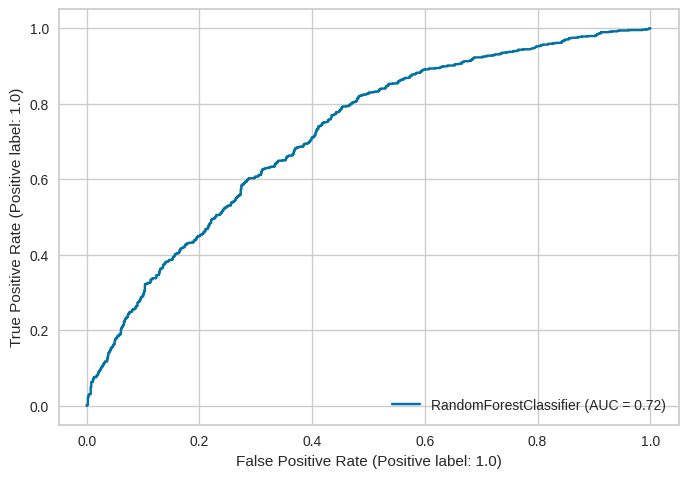

In [15]:
random_grid = RandomForestClassifier(criterion='gini', max_depth=5, max_features='log2', min_samples_leaf=2, min_samples_split=3, n_estimators=400, random_state=619, bootstrap=True, n_jobs = 4)
random_grid.fit(X_train, y_train)
random_pred=random_grid.predict(X_test)
print(classification_report(y_test,random_pred))
print(f'Train Accuracy: {random_grid.score(X_train,y_train)*100}%')
print(f'Test Accuracy: {random_grid.score(X_test,y_test)*100}%')
rf_accuracy=random_grid.score(X_test,y_test)*100
rf_accuracy=rf_accuracy.round(decimals=2)
roc_auc_score(y_test, random_grid.predict_proba(X_test)[:, 1])
rf_disp = RocCurveDisplay.from_estimator(random_grid, X_test, y_test)

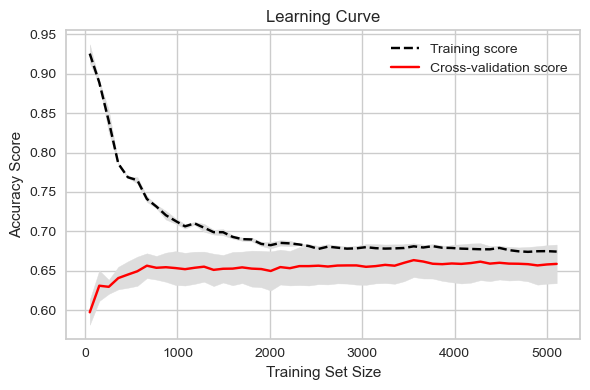

In [34]:
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(criterion='gini', max_depth=5, max_features='log2', min_samples_leaf=2, min_samples_split=3, n_estimators=400, bootstrap=True, random_state=655), 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="black",  label="Training score")
plt.plot(train_sizes, test_mean, color="red", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

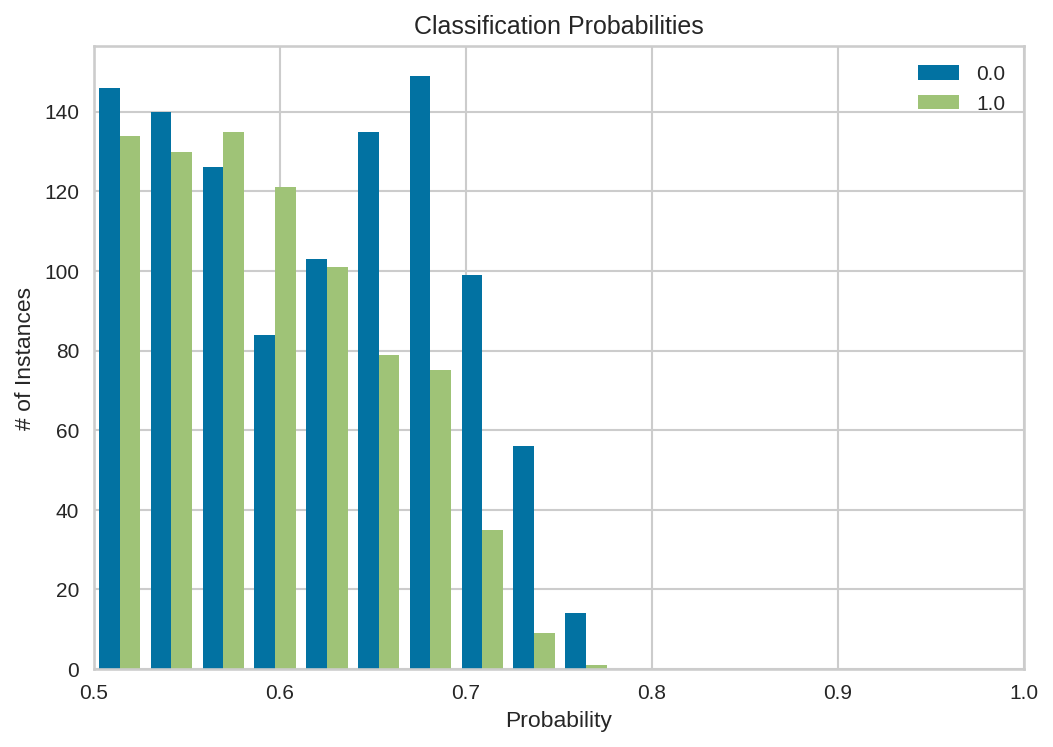

In [16]:
# get the probability distribution
probas = random_grid.predict_proba(X_test)# plot
plt.figure(dpi=150)
plt.hist(probas, bins=20)
plt.title('Classification Probabilities')
plt.xlabel('Probability')
plt.ylabel('# of Instances')
plt.xlim([0.5, 1.0])
plt.legend(data['title'])
plt.show()

###For most instances, the classifier is not very confident of its determination (note the tall bars at 0 and 1 on the x-axis). 
### In most of the cases, it’s nearly a coin toss (0.5 on the x-axis). And you’ll note that it’s more uncertain about data scientists (our minority class) than non-data scientist instances.

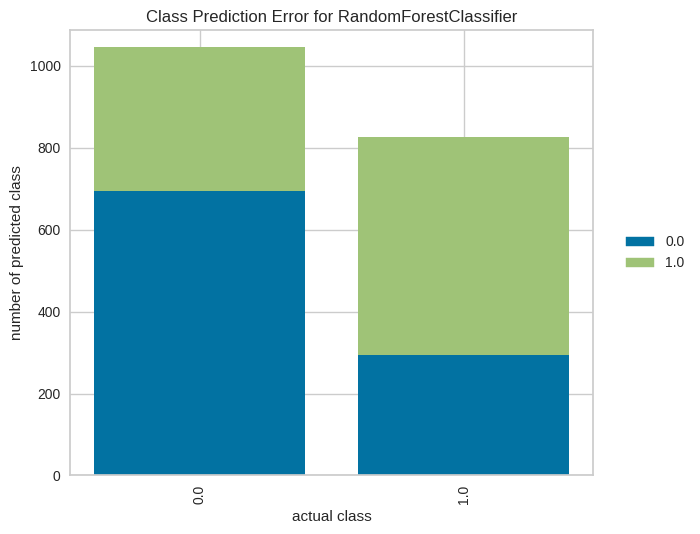

<AxesSubplot:title={'center':'Class Prediction Error for RandomForestClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [17]:
# Instantiate the classification model and visualizer
visualizerrf = ClassPredictionError(RandomForestClassifier(criterion='gini', max_depth=5, max_features='log2', min_samples_leaf=2, min_samples_split=3, n_estimators=400, bootstrap=True, random_state=655))

# Fit the training data to the visualizer
visualizerrf.fit(X_train, y_train)

# Evaluate the model on the test data
visualizerrf.score(X_test, y_test)

# Draw visualization
visualizerrf.show()

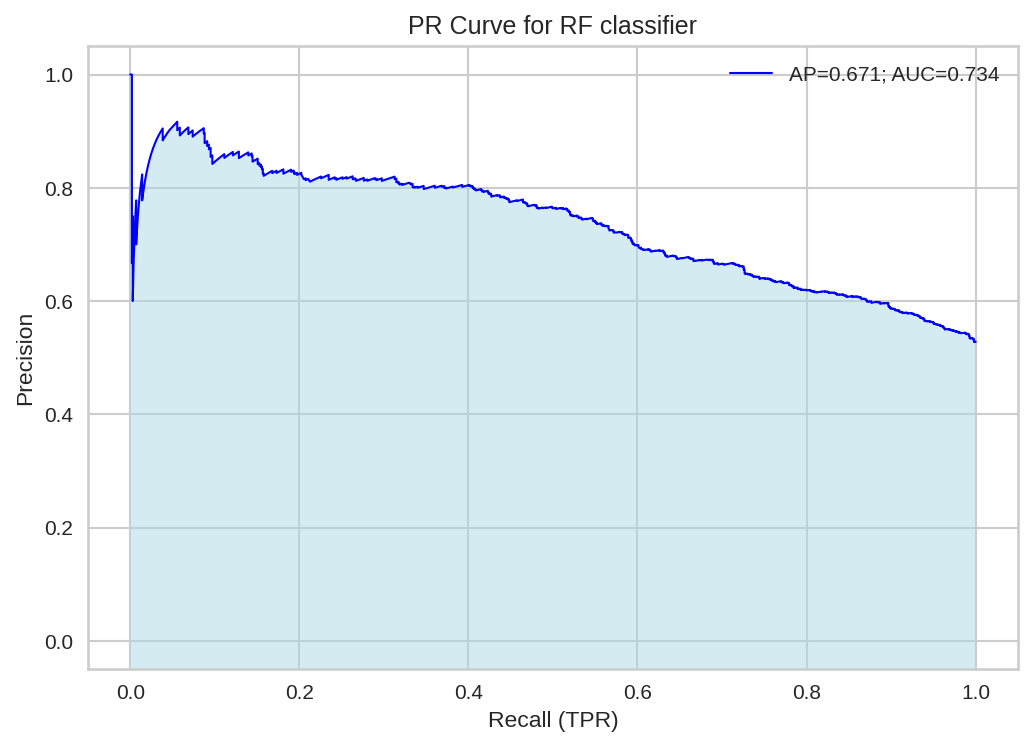

In [18]:
# get precision and recall values
precision, recall, thresholds = precision_recall_curve(y_test, probas[:,0], pos_label=0)# average precision score
avg_precision = average_precision_score(y_test, probas[:,1])# precision auc
pr_auc = auc(recall, precision)# plot
plt.figure(dpi=150)
plt.plot(recall, precision, lw=1, color='blue', label=f'AP={avg_precision:.3f}; AUC={pr_auc:.3f}')
plt.fill_between(recall, precision, -1, facecolor='lightblue', alpha=0.5)
plt.title('PR Curve for RF classifier')
plt.xlabel('Recall (TPR)')
plt.ylabel('Precision')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend()
plt.show()
### The precision-recall curve shows the tradeoff between precision and recall for different threshold. 
### A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate.

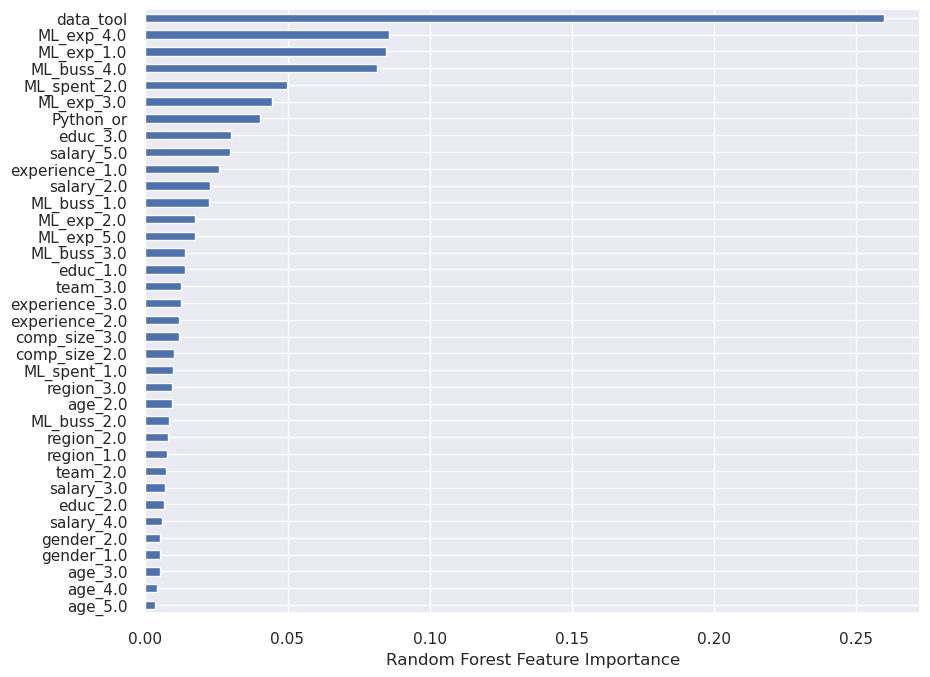

In [20]:
# Feature importance: SHAP and Permutation-based
sns.set(rc = {'figure.figsize':(10,8)})
feature_imp=pd.Series(random_grid.feature_importances_, data_vis.columns).sort_values()
feature_imp.plot(kind='barh')
plt.xlabel("Random Forest Feature Importance")
plt.savefig('RF_featureimp.png')
plt.show()

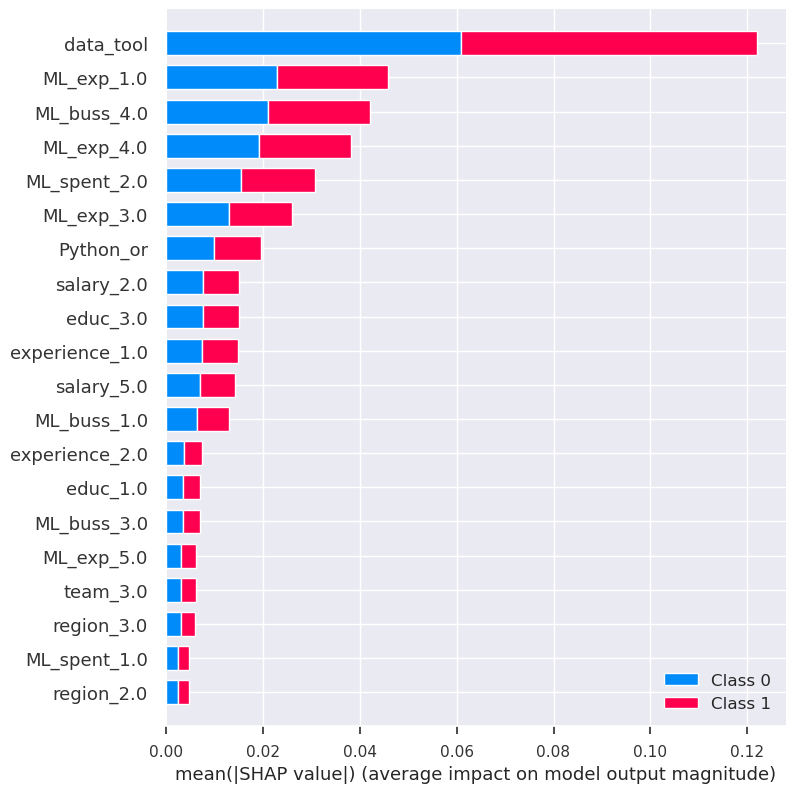

In [21]:
### SHAP builds model explanations by asking the same question for every prediction and feature: “How does prediction i change when feature j is removed from the model?” So-called SHAP values are the answers
### They quantify the magnitude and direction (positive or negative) of a feature’s effect on a prediction.
explainer_rf = shap.TreeExplainer(random_grid)
shap_values_rf = explainer_rf.shap_values(X_test)
shap.summary_plot(shap_values_rf, X_test, data_vis.columns)

### Here we have used the force plot to plot outcomes from the model. By visualizing the force plot we can understand the impact of every feature on the prediction by the model even for a specific instance of the data. The Force plot shows the influence of each feature on the current prediction. Values in the blue colour can be considered as the values that have a positive influence on the prediction whereas values in the red colour have a negative influence on the prediction.

In [24]:
shap.initjs()
shap.force_plot(explainer_rf.expected_value[0], shap_values_rf[0], X_test)

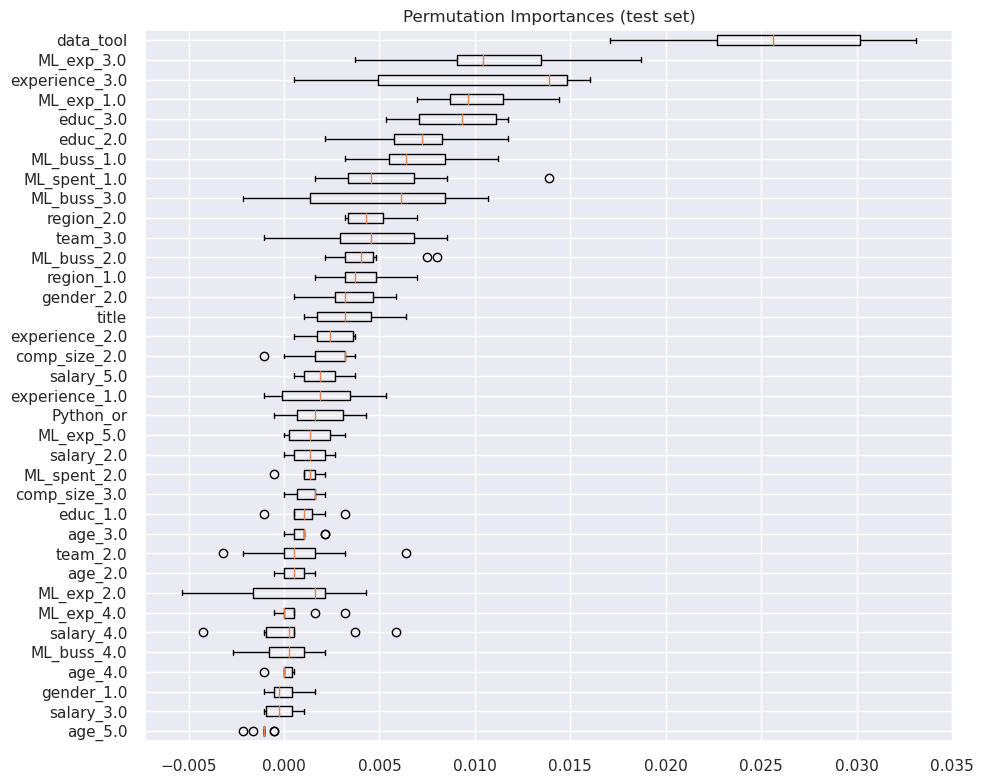

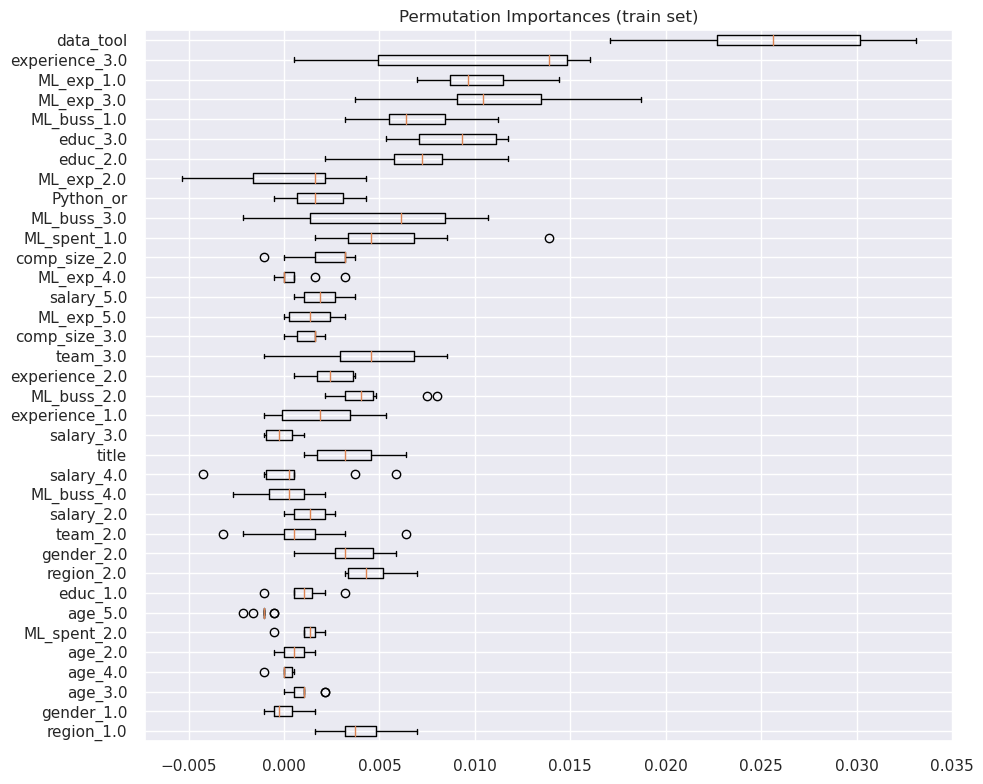

In [25]:
# Permutation-based feature importance
perm_importance = permutation_importance(random_grid,X_test, y_test)
result = permutation_importance(random_grid, X_test, y_test, n_repeats=10, random_state=412, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots()
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=data.columns[sorted_idx]
)
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

result2 = permutation_importance(random_grid, X_train, y_train, n_repeats=10, random_state=412, n_jobs=-1)
sorted_idx2 = result2.importances_mean.argsort()
fig, ax = plt.subplots()
ax.boxplot(
    result.importances[sorted_idx2].T, vert=False, labels=data.columns[sorted_idx2]
)
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

### Fifth ALGORITHM: XgBooster

In [42]:
### Before executing grid search algorithms, a benchmark model has to be fitted.By calling the fit() method, default parameters are obtained and stored for later use.

#dictionary for collecting results
results_dict = {}

#obtaining default parameters by calling .fit() to XGBoost model instance
xgbc0 = xgb.XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False)
xgbc0.fit(X_train , y_train)

#extracting default parameters from benchmark model
default_params = {}
gparams = xgbc0.get_params()

#default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
for key in gparams.keys():
    gp = gparams[key]
    default_params[key] = [gp]

#benchmark model. Grid search is not performed, since only single values are provided as parameter grid.
#However, cross-validation is still executed
clf0 = GridSearchCV(estimator=xgbc0, scoring='accuracy', param_grid=default_params, return_train_score=True, verbose=1, cv=3)
clf0.fit(X_train, y_train)

#results dataframe
df = pd.DataFrame(clf0.cv_results_)

#predictions - inputs to confusion matrix
train_predictions = clf0.predict(X_train)
test_predictions = clf0.predict(X_test)

#confusion matrices
cfm_train = confusion_matrix(y_train, train_predictions)
cfm_test = confusion_matrix(y_test, test_predictions)

#accuracy scores
accs_train = accuracy_score(y_train, train_predictions)
accs_test = accuracy_score(y_test, test_predictions)

#F1 scores for each train/test label
f1s_train_p1 = f1_score(y_train, train_predictions, pos_label=1)
f1s_train_p0 = f1_score(y_train, train_predictions, pos_label=0)
f1s_test_p1 = f1_score(y_test, test_predictions, pos_label=1)
f1s_test_p0 = f1_score(y_test, test_predictions, pos_label=0)


#Area Under the Receiver Operating Characteristic Curve
test_ras = roc_auc_score(y_test, clf0.predict_proba(X_test)[:,1])

#best parameters
bp = clf0.best_params_

#storing computed values in results dictionary
results_dict['xgbc0'] = {'iterable_parameter': np.nan,
                         'classifier': deepcopy(clf0),
                         'cv_results': df.copy(),
                         'cfm_train': cfm_train,
                         'cfm_test': cfm_test,
                         'train_accuracy': accs_train,
                         'test_accuracy': accs_test,
                         'train F1-score label 1': f1s_train_p1,
                         'train F1-score label 0': f1s_train_p0,
                         'test F1-score label 1': f1s_test_p1,
                         'test F1-score label 0': f1s_test_p0,
                         'test roc auc score': test_ras,
                         'best_params': bp}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [43]:
### GRIDSEARCH 
#creating deepcopy of default parameters before manipulations
params = deepcopy(default_params)

#setting grid of selected parameters for iteration
param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7],
              'max_depth': [5,6,7,8,9,10,11,12,13,14],
              'n_estimators': [50,65,80,100,115,130,150],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]}

In [44]:
#start time
t0 = time.time()
#No. of jobs
gcvj = np.cumsum([len(x) for x in param_grid.values()])[-1]

#iteration loop. Each selected parameter iterated separately
for i,grid_key in enumerate(param_grid.keys()):
    
    #variable for measuring iteration time
    loop_start = time.time()
       
    #creating param_grid argument for GridSearchCV:
    #listing grid values of current iterable parameter and wrapping non-iterable parameter single values in list
    for param_key in params.keys():
        if param_key == grid_key:
            params[param_key] = param_grid[grid_key]
        else:
            #use best parameters of last iteration
            try:
                param_value = [clf.best_params_[param_key]]
                params[param_key] = param_value
            #use benchmark model parameters for first iteration
            except:
                param_value = [clf0.best_params_[param_key]]
                params[param_key] = param_value
    
    #classifier instance of current iteration
    xgbc = xgb.XGBClassifier(**default_params)
    
    #GridSearch instance of current iteration
    clf = GridSearchCV(estimator=xgbc, param_grid=params, scoring='accuracy', return_train_score=True, verbose=1, cv=3)
    clf.fit(X_train, y_train)
    
    #results dataframe
    df = pd.DataFrame(clf.cv_results_)
    
    #predictions - inputs to confusion matrix
    train_predictions = clf.predict(X_train)
    test_predictions = clf.predict(X_test)
    
    #confusion matrices
    cfm_train = confusion_matrix(y_train, train_predictions)
    cfm_test = confusion_matrix(y_test, test_predictions)
    
    #accuracy scores
    accs_train = accuracy_score(y_train, train_predictions)
    accs_test = accuracy_score(y_test, test_predictions)
    
    #F1 scores for each train/test label
    f1s_train_p1 = f1_score(y_train, train_predictions, pos_label=1)
    f1s_train_p0 = f1_score(y_train, train_predictions, pos_label=0)
    f1s_test_p1 = f1_score(y_test, test_predictions, pos_label=1)
    f1s_test_p0 = f1_score(y_test, test_predictions, pos_label=0)
    
    #Area Under the Receiver Operating Characteristic Curve
    test_ras = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
    
    #best parameters
    bp = clf.best_params_
    
    #storing computed values in results dictionary
    results_dict[f'xgbc{i+1}'] = {'iterable_parameter': grid_key,
                                  'classifier': deepcopy(clf),
                                  'cv_results': df.copy(),
                                  'cfm_train': cfm_train,
                                  'cfm_test': cfm_test,
                                  'train_accuracy': accs_train,
                                  'test_accuracy': accs_test,
                                  'train F1-score label 1': f1s_train_p1,
                                  'train F1-score label 0': f1s_train_p0,
                                  'test F1-score label 1': f1s_test_p1,
                                  'test F1-score label 0': f1s_test_p0,
                                  'test roc auc score': test_ras,
                                  'best_params': bp}
    
    #variable for measuring iteration time
    elapsed_time = time.time() - loop_start
    print(f'iteration #{i+1} finished in: {elapsed_time} seconds')

#stop time
t1 = time.time()

#elapsed time
gcvt = t1 - t0

Fitting 3 folds for each of 13 candidates, totalling 39 fits
iteration #1 finished in: 8.94959020614624 seconds
Fitting 3 folds for each of 12 candidates, totalling 36 fits
iteration #2 finished in: 8.039562463760376 seconds
Fitting 3 folds for each of 10 candidates, totalling 30 fits
iteration #3 finished in: 18.0956768989563 seconds
Fitting 3 folds for each of 7 candidates, totalling 21 fits
iteration #4 finished in: 4.567309856414795 seconds
Fitting 3 folds for each of 13 candidates, totalling 39 fits
iteration #5 finished in: 3.963447093963623 seconds
Fitting 3 folds for each of 13 candidates, totalling 39 fits
iteration #6 finished in: 4.648568153381348 seconds


In [ ]:
### Coordinate descent is a special case in the sense, that performance of subsequent iterations are tracked and can be visualized for selecting the best parameter settings.
### Plots are as follows: evaluation scores for each trial of selected hyperparameter grid, along with a confusion matrix for best hyperparameter value evolution of evaluation scores for best parameter values of subsequent iterations.

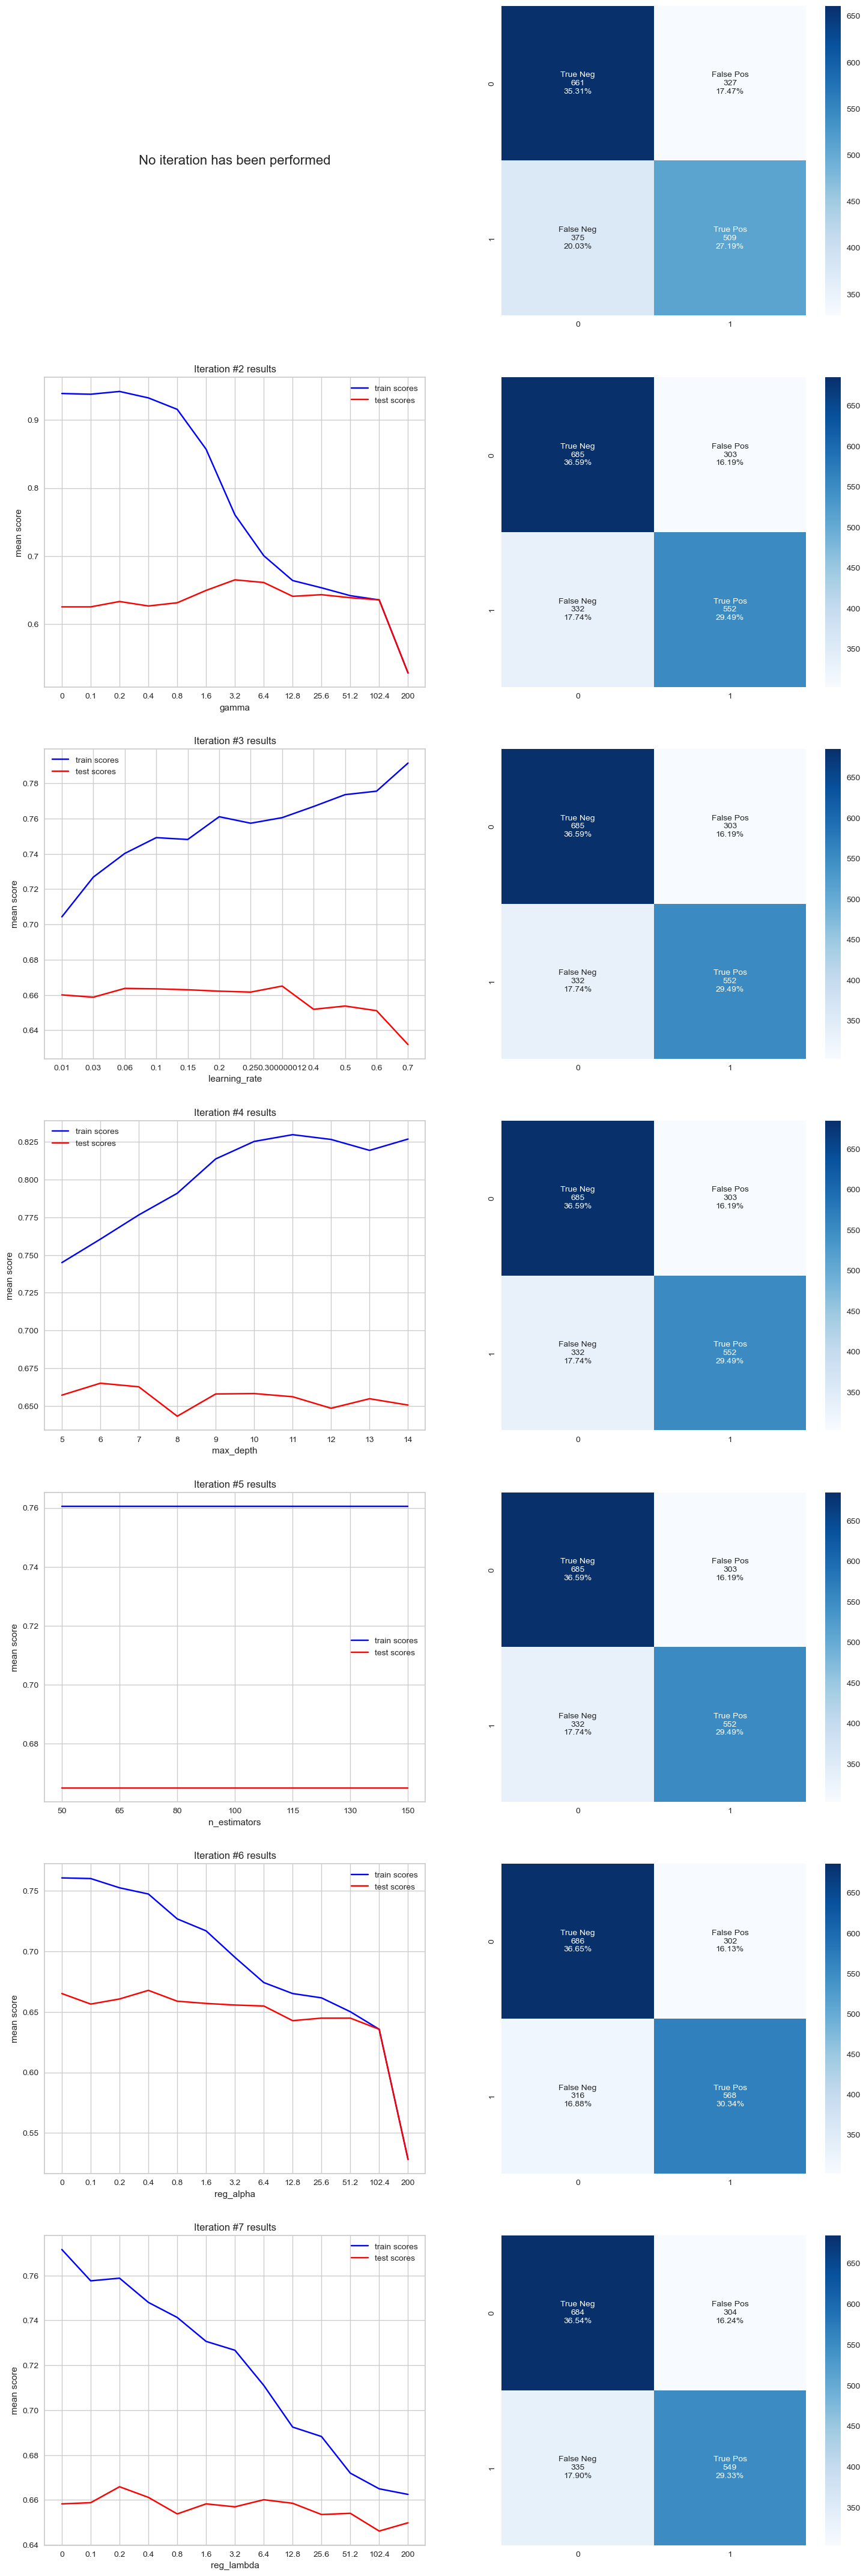

In [46]:
#number of rows depend on number of iterations
nrows = len(results_dict.keys())

#standard group names for confusion matrices
group_names = ['True Neg','False Pos','False Neg','True Pos']

#creating figure
f, axes = plt.subplots(nrows,2,figsize=(18,8*nrows));

#iteratively plotting train/test accuracy scores and test confusion matrix
for i,ax in enumerate(axes):
    
    #current key of results dictionary
    ckey = list(results_dict.keys())[i] 
    
    #plotting scores for models other than the benchark model
    if ckey != 'xgbc0':
        x1 = results_dict[ckey]['cv_results'].loc[:,'mean_train_score']
        x2 = results_dict[ckey]['cv_results'].loc[:,'mean_test_score']
        
        ax[0].plot(x1, label='train scores', color='blue');
        ax[0].plot(x2, label='test scores', color='red');
        ax[0].set_title(f'Iteration #{i+1} results');
               
        ax[0].set_xticks(list(range(0,len([x[results_dict[ckey]['iterable_parameter']] for x in results_dict[ckey]['cv_results']['params']]))));
        ax[0].set_xticklabels(sorted([x[results_dict[ckey]['iterable_parameter']] for x in results_dict[ckey]['cv_results']['params']]));
    
        ax[0].grid('major');
        ax[0].legend();
        ax[0].set_xlabel(results_dict[ckey]['iterable_parameter'])
        ax[0].set_ylabel('mean score');
    
    #leaving scores plot blank for benchmark model
    else:
        ax[0].axis('off')
        ax[0].text(x=0.5, y=0.5, s='No iteration has been performed', fontsize=16, va='center', ha='center')
    
    #computing variables for specific confusion matrix
    group_counts = ["{0:0.0f}".format(value) for value in results_dict[ckey]['cfm_test'].flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in results_dict[ckey]['cfm_test'].flatten()/np.sum(results_dict[ckey]['cfm_test'])]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    #plotting confusion matrix
    sns.heatmap(results_dict[ckey]['cfm_test'], annot=labels, fmt='', cmap='Blues', ax=ax[1])
    
plt.show();

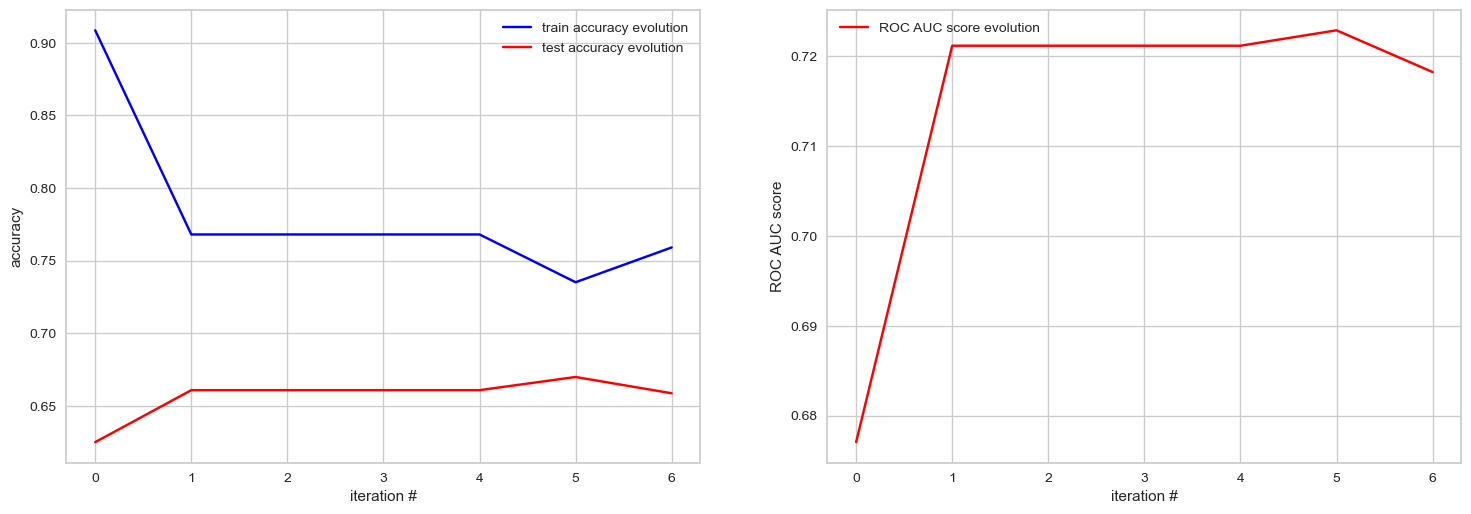

In [47]:
f, axes = plt.subplots(1,2,figsize=(18,6));

#plotting evolution of train/test accuracy scores for subsequent iterations
axes[0].plot([results_dict[key]['train_accuracy'] for key in results_dict.keys()], label='train accuracy evolution', color='blue');
axes[0].plot([results_dict[key]['test_accuracy'] for key in results_dict.keys()], label='test accuracy evolution', color='red');

#setting labels, drawing legend and major grid
axes[0].set_xlabel('iteration #');
axes[0].set_ylabel('accuracy');
axes[0].legend();
axes[0].grid('major');

#plotting evolution of test ROC AUC scores for subsequent iterations
axes[1].plot([results_dict[key]['test roc auc score'] for key in results_dict.keys()], label='ROC AUC score evolution', color='red');

#setting labels, drawing legend and major grid
axes[1].set_xlabel('iteration #');
axes[1].set_ylabel('ROC AUC score');
axes[1].legend();
axes[1].grid('major');

plt.show();

In [ ]:
### Important note: test scores are not necessarily increased for each subsequent iteration, since cross-validation is performed over train data, while manual AUC score is computed using test data. Consequently, the final model parameters are picked manually.
## Randomized search is executed in a similar fashion, capturing the results in the same results dictiona

In [48]:
#start time
t0 = time.time()

#No. of jobs
rcvj = gcvj

#unwrapping list values of default parameters
default_params_xgb = {}

for key in default_params.keys():
    default_params_xgb[key] = default_params[key][0]

#providing default parameters to xgbc model, before randomized search cross-validation
xgbc = xgb.XGBClassifier(**default_params_xgb)

#Executing Randomized Search
clf_random = RandomizedSearchCV(estimator=xgbc, param_distributions=param_grid, scoring='accuracy', return_train_score=True, verbose=1, cv=3, n_iter=rcvj)
clf_random.fit(X_train, y_train)
    
#results dataframe
df = pd.DataFrame(clf_random.cv_results_)
    
#predictions - inputs to confusion matrix
train_predictions = clf_random.predict(X_train)
test_predictions = clf_random.predict(X_test)
    
#confusion matrices
cfm_train = confusion_matrix(y_train, train_predictions)
cfm_test = confusion_matrix(y_test, test_predictions)
    
#accuracy scores
accs_train = accuracy_score(y_train, train_predictions)
accs_test = accuracy_score(y_test, test_predictions)
    
#F1 scores for each train/test label
f1s_train_p1 = f1_score(y_train, train_predictions, pos_label=1)
f1s_train_p0 = f1_score(y_train, train_predictions, pos_label=0)
f1s_test_p1 = f1_score(y_test, test_predictions, pos_label=1)
f1s_test_p0 = f1_score(y_test, test_predictions, pos_label=0)

    
#Area Under the Receiver Operating Characteristic Curve
test_ras = roc_auc_score(y_test, clf_random.predict_proba(X_test)[:,1])
    
#best parameters
bp = clf_random.best_params_
    
#storing computed values in results dictionary
results_dict['xgbc_rcv'] = {'classifier': deepcopy(clf_random),
                            'cv_results': df.copy(),
                            'cfm_train': cfm_train,
                            'cfm_test': cfm_test,
                            'train_accuracy': accs_train,
                            'test_accuracy': accs_test,
                            'train F1-score label 1': f1s_train_p1,
                            'train F1-score label 0': f1s_train_p0,
                            'test F1-score label 1': f1s_test_p1,
                            'test F1-score label 0': f1s_test_p0,
                            'test roc auc score': test_ras,
                            'best_params': bp}

#stop time
t1 = time.time()

#elapsed time
rcvt = t1 - t0

Fitting 3 folds for each of 68 candidates, totalling 204 fits


In [49]:
### Finally, the AUC scores and elapsed search time are compared.
#printing benchmark, iterative grid search and randomized search ROC AUC / accuracy scores (test data set)
print(f"Benchmark AUC/accuracy score: {np.round(results_dict['xgbc0']['test roc auc score'],4)} / {np.round(results_dict['xgbc0']['test_accuracy'],4)}")
print(f"Coordinate descent AUC/accuracy score: {np.round(results_dict['xgbc3']['test roc auc score'],4)} / {np.round(results_dict['xgbc3']['test_accuracy'],4)} @ {np.round(gcvt/60,2)} minutes and {gcvj} jobs")
print(f"Randomized search AUC/accuracy score: {np.round(results_dict['xgbc_rcv']['test roc auc score'],4)} / {np.round(results_dict['xgbc_rcv']['test_accuracy'],4)} @ {np.round(rcvt/60,2)} minutes and {rcvj} jobs")
print("")

#computing expected time of executing exhaustive grid search
jobs = np.cumprod([len(x) for x in param_grid])[-1]
et = jobs * gcvt / gcvj
print(f"Expected time of executing exhaustive grid search with 3-fold cross-validation: {int(et/60)} minutes and {jobs} jobs")

Benchmark AUC/accuracy score: 0.6771 / 0.625
Coordinate descent AUC/accuracy score: 0.7212 / 0.6608 @ 0.8 minutes and 68 jobs
Randomized search AUC/accuracy score: 0.7223 / 0.6603 @ 0.87 minutes and 68 jobs

Expected time of executing exhaustive grid search with 3-fold cross-validation: 7473 minutes and 631800 jobs


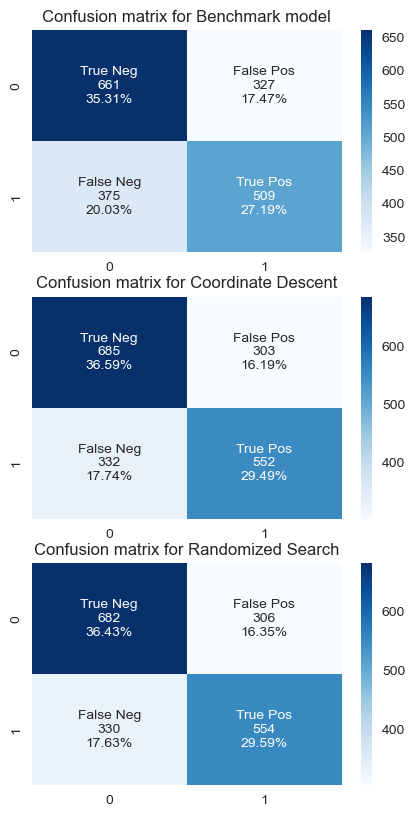

In [50]:
keys = ['xgbc0', 'xgbc3', 'xgbc_rcv']
titles = ['Benchmark model', 'Coordinate Descent', 'Randomized Search']

f, axes = plt.subplots(3,figsize=(5,10));

for i,ax in enumerate(axes.flatten()):
    
    #computing variables for specific confusion matrix
    group_counts = ["{0:0.0f}".format(value) for value in results_dict[keys[i]]['cfm_test'].flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in results_dict[keys[i]]['cfm_test'].flatten()/np.sum(results_dict[keys[i]]['cfm_test'])]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    #plotting confusion matrix
    sns.heatmap(results_dict[keys[i]]['cfm_test'], annot=labels, fmt='', cmap='Blues', ax=ax)
    ax.set_title(f"Confusion matrix for {titles[i]}")

In [51]:
# save the best accuracy score (randomizedsearch) as an object (first convert dictionary to a list and then an array, and finally subset the array)
# the dictionary = results_dict['xgbc_rcv']
my_list = list(results_dict['xgbc_rcv'].values())
xg_random_arr = np.asarray(my_list,dtype="object")
xgb_accuracy=xg_random_arr[5]
xgb_accuracy=xgb_accuracy*100
xgb_accuracy=xgb_accuracy.round(decimals=2)
print(xgb_accuracy)

66.03


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Accuracy: 66.24%


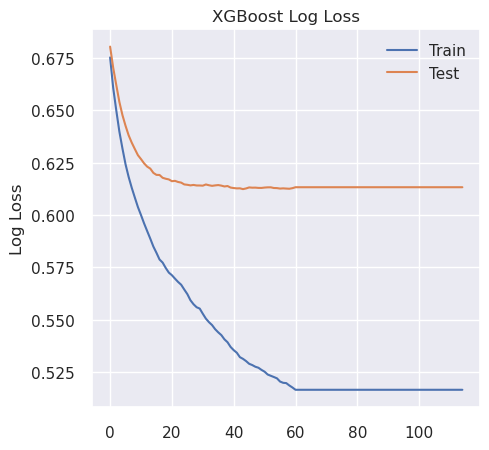

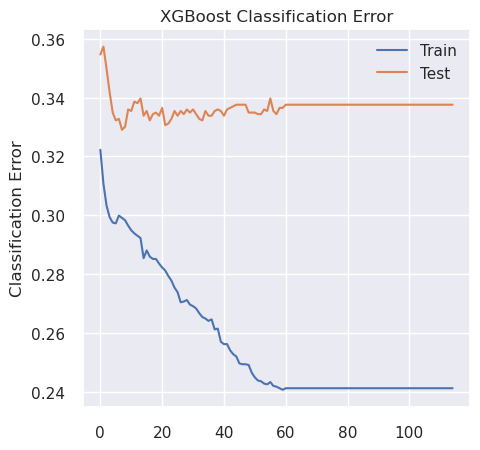

In [26]:
# fit model no training data
model = XGBClassifier(reg_lambda= 0, reg_alpha= 0, n_estimators= 115, max_depth= 6, learning_rate= 0.1, gamma= 3.2)
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)
    
 # make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
    
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
    
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
    
# plot log loss
fig, ax = pyplot.subplots(figsize=(5,5))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
    
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
    
    
# plot classification error
fig, ax = pyplot.subplots(figsize=(5,5))
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
    
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

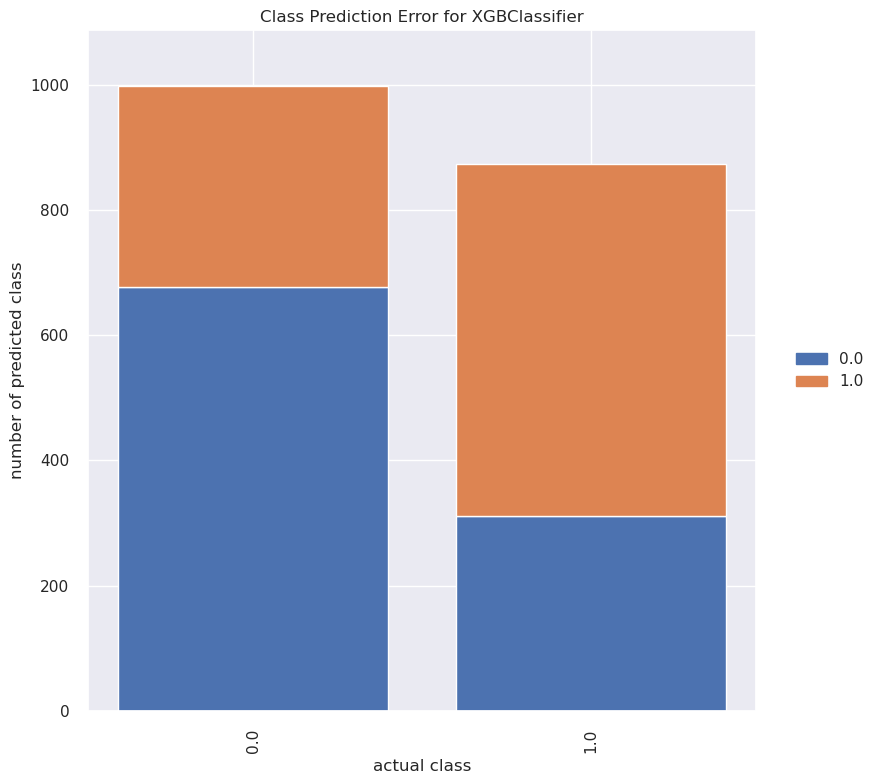

<AxesSubplot:title={'center':'Class Prediction Error for XGBClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [27]:
# Instantiate the classification model and visualizer
visualizerxg = ClassPredictionError(XGBClassifier(reg_lambda= 0, reg_alpha= 0, n_estimators= 115, max_depth= 6, learning_rate= 0.1, gamma= 3.2, use_label_encoder=False))

# Fit the training data to the visualizer
visualizerxg.fit(X_train, y_train)

# Evaluate the model on the test data
visualizerxg.score(X_test, y_test)

# Draw visualization
visualizerxg.show()

In [ ]:
# Are random forest and xgboost algorithms significantly different from each other?
t3, p3 = paired_ttest_5x2cv(estimator1=random_grid,
                          estimator2=model,
                          X=X, y=y,
                          random_seed=711)

print('t statistic: %.3f' % t3)
print('p value: %.3f' % p3)
### p value is 0.09 - I will take the threshold p<10% assume that this is a significant p-value since my model is not good enough. So, these algorithms differ from each other.

In [31]:
print(f'Train Accuracy: {model.score(X_train,y_train)*100}%')
print(f'Test Accuracy: {model.score(X_test,y_test)*100}%')
xgboost_accuracy=model.score(X_test,y_test)*100
xgboost_accuracy=xgboost_accuracy.round(decimals=2)

Train Accuracy: 75.88204318062138%
Test Accuracy: 66.23931623931624%


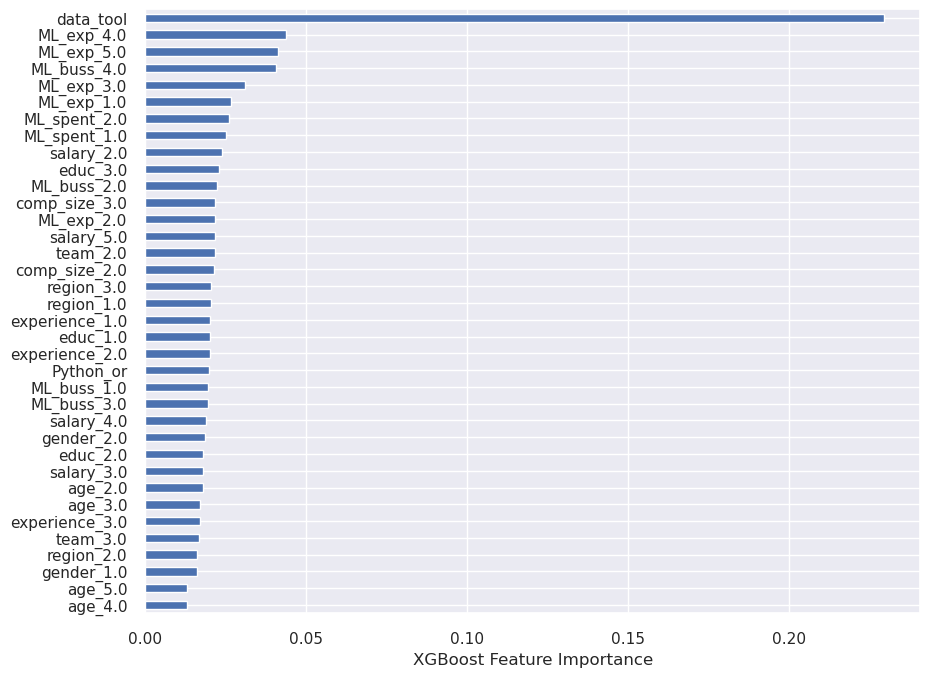

In [32]:
##Feature Importance
# Feature importance: SHAP and Permutation-based
sns.set(rc = {'figure.figsize':(10,8)})
feature_imp_xg=pd.Series(model.feature_importances_, data_vis.columns).sort_values()
feature_imp_xg.plot(kind='barh')
plt.xlabel("XGBoost Feature Importance")
plt.savefig('XGB_featureimp.png')
plt.show()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


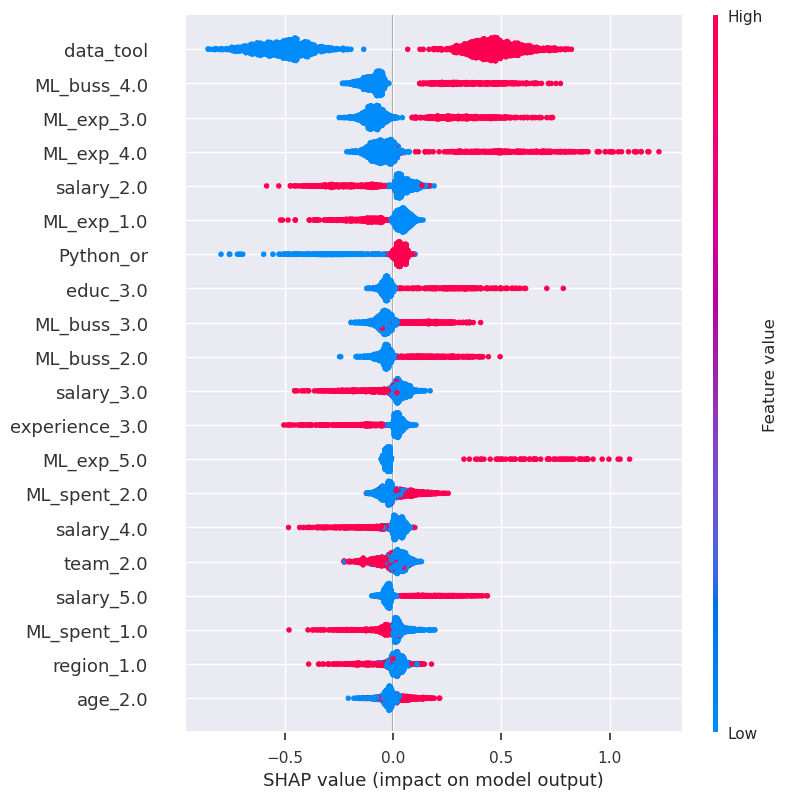

In [29]:
#SHAP
explainer_xgb = shap.TreeExplainer(model)
shap_values_xgb = explainer_xgb.shap_values(X_test)
shap.summary_plot(shap_values_xgb, X_test, data_vis.columns)

In [30]:
matrix_accuracy = np.vstack([gnb_accuracy, svmbest_accuracy, lr_accuracy, rf_accuracy, xgboost_accuracy])
mat_accuracy = np.transpose(matrix_accuracy)
accuracy_data = pd.DataFrame(mat_accuracy)
accuracy_data = accuracy_data.rename(columns={0:'Naive Bayes', 1:'Support Vector Machines', 2:'Logistic Regression', 3:'Random Forest', 4:'XG Boost'})
print(accuracy_data)

   Naive Bayes  Support Vector Machines  Logistic Regression  Random Forest  \
0        64.58                    67.04                66.29          65.92   

   XG Boost  
0     66.24  


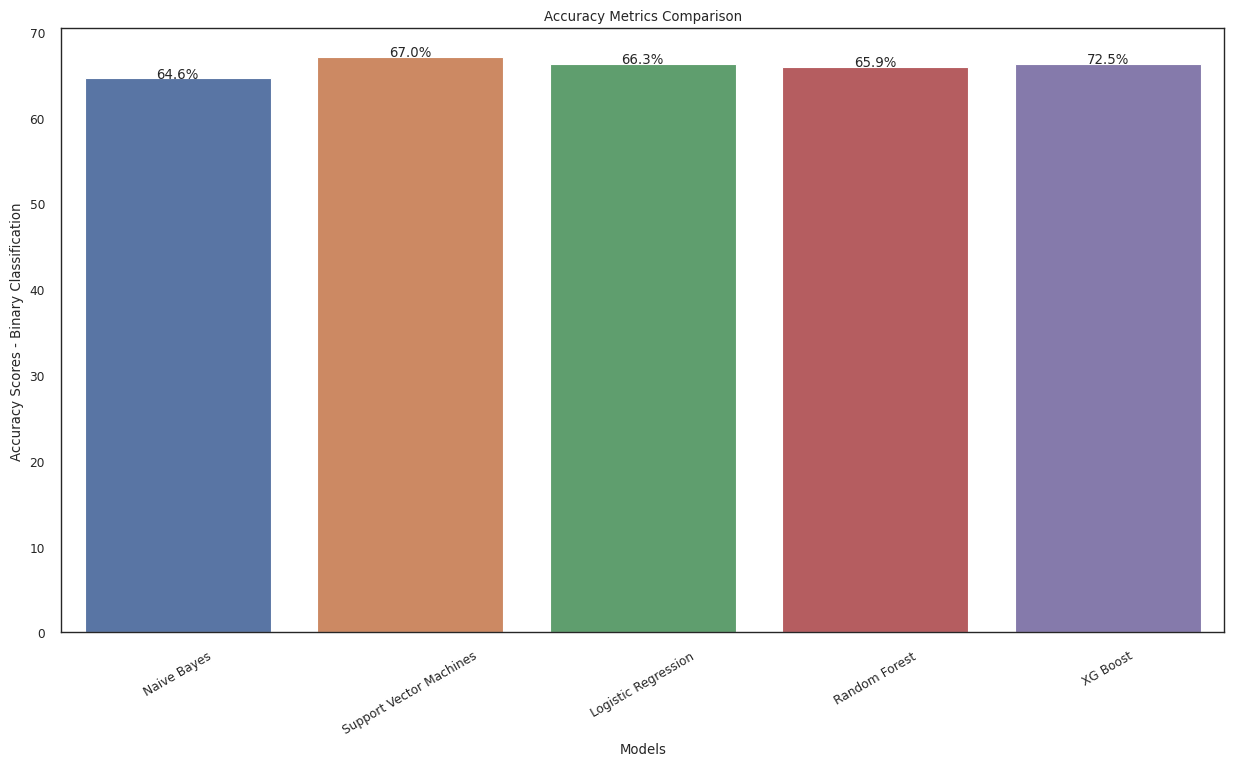

In [ ]:
###plot accuracy scores
sns.set(rc = {'figure.figsize':(15,8)})
sns.set_context('paper')
sns.set_style("white")
g=sns.barplot(data=accuracy_data)
g.set(xlabel="Models", ylabel="Accuracy Scores - Binary Classification")
plt.xticks(rotation=30)
g.set_title("Accuracy Metrics Comparison")
percentage = [64.58, 67.04, 66.29, 65.92, 72.49]
patches = g.patches
for i in range(len(patches)):
   x = patches[i].get_x() + patches[i].get_width()/2
   y = patches[i].get_height()+.08
   g.annotate('{:.1f}%'.format(percentage[i]), (x, y), ha='center')
plt.savefig('accuracy_metrics2.png')
plt.show()

In [ ]:
### Roc Curve Comparison
sns.set_context('talk')
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_estimator(gnb, X_test, y_test, ax=ax, name='Naive Bayes')
RocCurveDisplay.from_estimator(best_svm, X_test, y_test, ax=ax, name='SVC')
RocCurveDisplay.from_estimator(random_grid, X_test, y_test, ax=ax, name='Random Forest')
RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax, name='XGBoost')
plt.savefig('roc_curve_comparison.png')
plt.show()